<center><font size="6">Хакатон от Моторики</font>

[Третий этап](https://www.kaggle.com/competitions/motorica-advanced-gesture-classification)

Команда 1

**Задача:**  Построить классификационную модель, которая по показаниям оптомиографических датчиков будет определять жест оператора протеза кисти во время записи данных, что отражено в значении целевой переменной. 

Имеется три оператора, выполнявшие некоторую последовательность жестов. В результате наблюдений получены показания датчиков в виде непрерывного временного ряда. 

Список файлов, в котором символ * обозначает индекс оператора:
* X_train_*.npy - обучающая выборка, имеющая размерности "наблюдения, датчики, время";
* X_test_dataset_*.pkl - тестовая выборка, имеющая размерности "наблюдения, датчики, время";
* sample_submission.csv - некоторое решение задачи, из которого можно взять формат загрузки данных на Kaggle;
* y_train_*.npy - целевая переменная для обучающей выборки, которая содержит следующие классы:

| Номер <br> класса | Описание жеста |
| :---: | :--- |
| "-1"  |  потенциально "битые" данные |
| "0"  |  жест "open" - разгиб всех пальцев |
| "1"  |  жест "пистолет" |
| "2"  |  сгиб большого пальца |
| "3"  |  жест "ok" |
| "4"  |  жест "grab" |

* functions.py - библиотека функций, применяемых в данном ноутбуке.

# Import библиотек и описание функций

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import copy
import pickle
#import zipfile
from zipfile import ZipFile

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# отображать по умолчанию длину дата Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os

# Библиотека вызова функций, специально разработанных для данного ноутбука
import functions as f 

In [ ]:
# константы и глобальные параметры данных
PATH = 'data/'
GEST = 5          # количество основных жестов (кроме 'битых' данных)
PL = 3            # количество пилотов (независимых рядов данных)
SENS = 50         # количество датчиков

X_train = ['' for p in range(PL)]  # список объектов X_train
y_train = ['' for p in range(PL)]  # список объектов y_train
X_test = ['' for p in range(PL)]   # список объектов X_test

t_train = ['' for p in range(PL)]   # список длин X_train и y_train (кол-во временных тиков)
t_test = [0 for p in range(PL)]     # список с общим количеством временных тиков в X_test
s_test = ['' for p in range(PL)]    # список с количеством событий в X_test
tt_test = [[] for p in range(PL)]   # список списков с длинами событий в X_test

# Загрузка данных
---

In [ ]:
# Файлы можно хранить в архиве и читать прямо из него.
archive = ZipFile('data/motorica-advanced-gesture-classification.zip', 'r')

X_test_dataset_1 = archive.read('X_test_dataset_1.pkl')
X_test_dataset_2 = archive.read('X_test_dataset_2.pkl')
X_test_dataset_3 = archive.read('X_test_dataset_3.pkl')
X_train_1 = archive.read('X_train_1.npy')
X_train_2 = archive.read('X_train_2.npy')
X_train_3 = archive.read('X_train_3.npy')
y_train_1 = archive.read('y_train_1.npy')
y_train_2 = archive.read('y_train_2.npy')
y_train_3 = archive.read('y_train_3.npy')

In [ ]:
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

In [ ]:
# path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')
# from zipfile import *
# for mount_name, mount in mounts.items():
#     mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
#     mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
#     with ZipFile('.\data\motorica-advanced-gesture-classification.zip') as myzip:
#         with myzip.open(mount['path_X_test_dataset']) as myfile:
#             mount['X_test_dataset'] = pickle.load(myfile)
#     print(len(mount['X_test_dataset']))

In [23]:
# Чтение данных из архива (без распаковки архива)
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(len(mount['X_test_dataset']))

899
855
861


In [9]:
# загрузка обучающей выборки и меток классов, тестовой выборки
X_test_raw = ['' for p in range(PL)]
for p in range(PL):
    X_train[p] = np.load(os.path.join(PATH, 'X_train_' + f'{p+1}' + '.npy'))
    t_train[p] = X_train[p].shape[0]
    
    y_train[p] = np.load(os.path.join(PATH, 'y_train_' + f'{p+1}' + '.npy'))
    if y_train[p].shape[0] == t_train[p]:
        print(f'длина обучающей выборки пилота №{p+1} = {t_train[p]}')
    else:
        print(f'длина обучающей выборки и меток классов пилота №{p+1} не совпадают!')
    
    with open(os.path.join(PATH, 'X_test_dataset_' + f'{p+1}' + '.pkl'), 'rb') as file:
        X_test_raw[p] = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data/X_train_1.npy'

In [21]:
# смотрим на исходные данные X_train
print(f"Тип данных X_train: {type(mounts[1]['X_train'])}")
print(f"Размерность файла X_train_1: {mounts[1]['X_train'].shape} - время, датчики")
print(f"X_train первого пилота: \n {mounts[1]['X_train']}")

Тип данных X_train: <class 'numpy.ndarray'>
Размерность файла X_train_1: (24030, 50) - время, датчики
X_train первого пилота: 
 [[2711   16 1803 ...    8   14    7]
 [2712   10 1802 ...    6   12    6]
 [2711   13 1803 ...    5   16    8]
 ...
 [2707   16 1851 ...    6   13    6]
 [2707   18 1850 ...    8   12    6]
 [2710   16 1851 ...    9   11    8]]


In [19]:
# смотрим на исходные данные y_train
print(f"Тип данных y_train: {type(mounts[1]['y_train'])}")
print(f"Размерность файла y_train_1: {mounts[1]['y_train'].shape} - время")
print(f"y_train первого пилота: \n {mounts[1]['y_train']}")

Тип данных y_train: <class 'numpy.ndarray'>
Размерность файла y_train_1: (24030,) - время
y_train первого пилота: 
 [0 0 0 ... 3 3 3]


In [20]:
print('Тип данных X_test: ', type(X_test_raw[0]))
print(f'Размерность файла X_test_1: ({len(X_test_raw[0])}, {len(X_test_raw[0][0])}, '
      + f'{len(X_test_raw[0][0][0])}) - событие, датчики, время')
print('X_test первого пилота, событие "0":')
X_test_raw[0][0]

Тип данных X_test:  <class 'str'>


IndexError: string index out of range

In [16]:
# транспонируем np.array для каждого события в X_test
t_test = [0 for p in range(PL)]
X_test = copy.deepcopy(X_test_raw)
for p in range(PL):
    s_test[p] = len(X_test_raw[p])
    print(f'Количество событий для пилота №{p+1} = {s_test[p]}')
    for s in range(s_test[p]):
        X_test[p][s] = X_test[p][s].T
        tt_test[p].append(len(X_test[p][s]))
        t_test[p] += tt_test[p][s]
print(f'X_test первого пилота содержит всего {t_test[0]} временных тиков')
print(f'X_test первого пилота, событие "0" длиной {tt_test[0][0]} тиков:')
X_test[0][0]

Количество событий для пилота №1 = 899
Количество событий для пилота №2 = 855
Количество событий для пилота №3 = 861
X_test первого пилота содержит всего 161966 временных тиков
X_test первого пилота, событие "0" длиной 181 тиков:


array([[2869,   15, 1866, ...,    7,   13,    6],
       [2871,   12, 1865, ...,    7,   13,    6],
       [2876,   15, 1863, ...,    6,   14,    7],
       ...,
       [2937,   15, 1838, ...,    7,   14,    6],
       [2936,   17, 1836, ...,    8,   13,    7],
       [2938,   15, 1836, ...,    6,   13,    7]], dtype=int64)

# Look at `X_test_dataset`

In [ ]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"subject {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

subject 1
	shape (50, 105) appears 303 times.
	shape (50, 181) appears 299 times.
	shape (50, 256) appears 297 times.
subject 2
	shape (50, 105) appears 286 times.
	shape (50, 181) appears 285 times.
	shape (50, 256) appears 284 times.
subject 3
	shape (50, 105) appears 291 times.
	shape (50, 181) appears 282 times.
	shape (50, 256) appears 288 times.


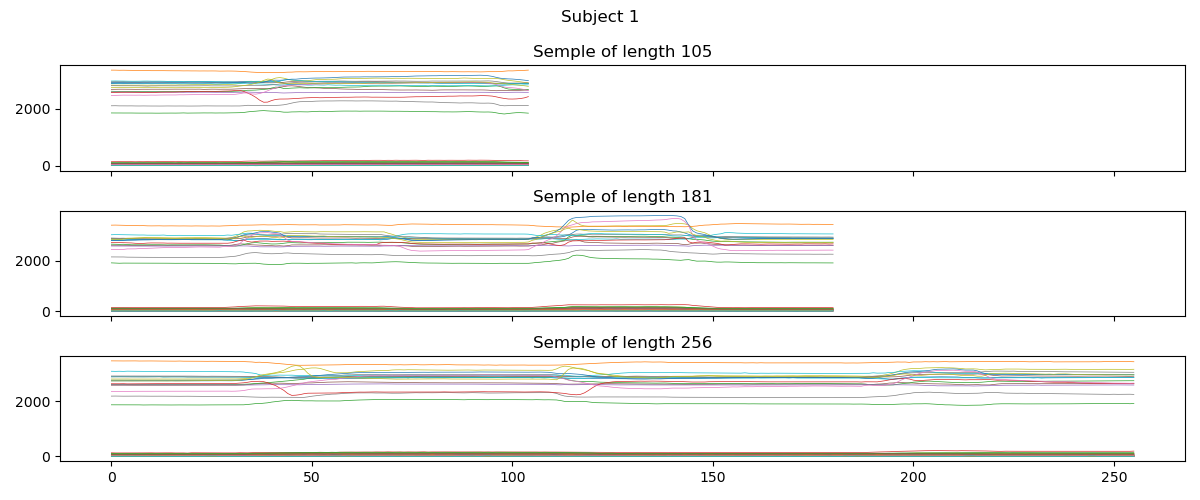

In [ ]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_test_dataset[3].T, lw=0.5)
    plt.title('Sample of length 105')
    
    plt.sca(axx[1])
    plt.plot(X_test_dataset[1].T, lw=0.5)
    plt.title('Sample of length 181')
    
    plt.sca(axx[2])
    plt.plot(X_test_dataset[8].T, lw=0.5)
    plt.title('Sample of length 256')
    
    plt.suptitle(f"Subject {mount_name}")
    plt.tight_layout()
    plt.show()
    
    break

In [17]:
print('X_train первого пилота:')
X_train[0].shape

X_train первого пилота:


(24030, 50)

In [18]:
active_sensors, passive_sensor = f.get_sensor_list(0, X_train, print_active=True)

Активные датчики пилота 0:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики пилота 0:  [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [19]:
f.get_all_sensors_plot(1, [0,107], X_train, plot_counter=1)

In [22]:
f.get_active_passive_sensors_plot(1, X_train, plot_counter=2)